In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging 

import shap
from pdpbox import pdp
from pycebox.ice import ice, ice_plot

from sklearn import tree, ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [4]:
import random

import plotly.graph_objs as go
from sklearn.metrics import roc_curve, precision_recall_curve



def plot_observation_contribution(interpretable_dict,
                                  index_ref,
                                  num_features_plot=5,
                                  is_horizontal=False
                                  ):
    """Compute plotly figure of contributions for one explanation
    (local interpretability).

    Parameters
    ----------
    interpretable_dict : dict,
        Dictionnary with post-processed data and contributions
        (see .postprocessing module for more information).

    index_ref : int,
        Number of line of DataFrame that should be plot.

    num_features : int, optional
        Number of features that should be plot (ordered by decreasing
        contribution).

    is_horizontal : bool, optional
        True if figure should be plot horizontally, False otherwise.

    Returns
    -------
    fig : plotly figure,
        Plotly figure of contributions.
    """

    contrib = interpretable_dict['contrib'].iloc[index_ref,:]
    bias = interpretable_dict['bias']
    pred = interpretable_dict['pred'][index_ref]

    contribution = pd.DataFrame(
        interpretable_dict['contrib'].columns.tolist(),
        columns=['variable'])
    contribution['contribution'] = contrib.values

    contribution = contribution.assign(sortval = np.abs(
        contribution.contribution))\
        .sort_values('sortval', ascending=False)\
        .drop('sortval', 1)

    contribution = contribution.iloc[:num_features_plot,:].append({
        contribution.columns[0]: '_OTHERS_',
        contribution.columns[1]: sum(contribution.iloc[num_features_plot:,1])
    }, ignore_index=True)

    data, layout = compute_waterfall_contribution(
        contribution,
        bias,
        delta_y_display=0.02)

    if is_horizontal:
        data, layout = make_waterfall_horizontal(data, layout)

    fig = go.Figure(data=data, layout=layout)
    return fig


def compute_waterfall_contribution(contribution, bias,
                                   n_round=3, delta_y_display=0.05,
                                   hover_value='x'):
    """Function used to compute plotly traces for a waterfall display.
    """

    ## Compute the 4 traces list
    base = [0]
    positive = [bias]
    negative = [0]
    total = [0]
    text = [str(round(bias, n_round))]
    y_text = [bias + delta_y_display]

    for contrib in contribution['contribution']:
        base.append(base[-1] + positive[-1])
        total.append(0)
        if contrib>=0:
            negative.append(0)
            positive.append(contrib)
            text.append('+' + str(round(contrib, n_round)))
        else:
            positive.append(0)
            negative.append(-contrib)
            base[-1] = base[-1] + contrib
            text.append(str(round(contrib, n_round)))

        y_text.append(base[-1] + negative[-1] + positive[-1] + delta_y_display)

    total.append(base[-1] + positive[-1])
    base.append(0)
    positive.append(0)
    negative.append(0)
    text.append(str(round(total[-1] + negative[-1], n_round)))
    y_text.append(total[-1] + delta_y_display)

    ## Create the 4 traces
    x_data = ['_BASE RATE_'] + list(contribution['variable']) + ['Prediction']
    trace_base = go.Bar(x=x_data, y=base,
    marker=dict(
        color='rgba(1,1,1, 0.0)',
    ),
    hoverinfo=hover_value)
    trace_positive = go.Bar(x=x_data, y=positive,
    marker=dict(
        color='rgba(55, 128, 191, 0.7)',
        line=dict(
            color='rgba(55, 128, 191, 1.0)',
            width=2,
        )
    ),
    hoverinfo=hover_value)
    trace_negative = go.Bar(x=x_data, y=negative,
    marker=dict(
        color='rgba(255, 128, 0, 0.7)',
        line=dict(
            color='rgba(255, 128, 0, 1.0)',
            width=2,
        )
    ),
    hoverinfo=hover_value)
    trace_total = go.Bar(x=x_data, y=total,
    marker=dict(
        color='rgba(50, 171, 96, 0.7)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=2,
        )
    ),
    hoverinfo=hover_value)

    data = [trace_base, trace_positive, trace_negative, trace_total]


    annotations = []
    for i in range(len(text)):
        annotations.append(dict(x=x_data[i], y=y_text[i], text=text[i],
                                  font=dict(family='Arial', size=14,
                                  color='rgba(0, 0, 0, 1)'),
                                  showarrow=False,))

    layout = go.Layout(
                barmode='stack',
                xaxis={'title': ''},
                yaxis={'title': 'Prediction score'#,
                    #'range': [0.0, 1.1]
                    },
                title='Score breakdown by variable contribution',
                margin=go.Margin(
                    l=200,
                    r=20,
                    b=100,
                    t=50,
                    pad=4
                ),
                #paper_bgcolor='rgba(245, 246, 249, 1)',
                #plot_bgcolor='rgba(245, 246, 249, 1)',
                showlegend=False
            )
    layout['annotations'] = annotations

    return data, layout


def hoverinfo_horizontal_(hover_value):
    """Function used to update the hoverinfo relevantly when the
    plot is made horizontal.
    """
    if hover_value == "x":
        horizontal_hover_value = "y"
    if hover_value == "y":
        horizontal_hover_value = "x"
    if hover_value == "x+text":
        horizontal_hover_value = "y+text"
    if hover_value == "y+text":
        horizontal_hover_value = "x+text"
    if hover_value == "text":
        horizontal_hover_value = "text"
    return horizontal_hover_value


def make_waterfall_horizontal(data, layout):
    """Function used to flip the figure from vertical to horizontal.
    """
    h_data = list(data)
    h_data = []
    for i_trace, trace in enumerate(list(data)):
        h_data.append(trace)
        prov_x = h_data[i_trace]['x']
        h_data[i_trace]['x'] = list(h_data[i_trace]['y'])[::-1]
        h_data[i_trace]['y'] = list(prov_x)[::-1]
        h_data[i_trace]['orientation'] = 'h'
        h_data[i_trace]['hoverinfo'] = hoverinfo_horizontal_(
            h_data[i_trace]['hoverinfo'])

    h_annotations = []
    for i_ann, annotation in enumerate(list(layout['annotations'])):
        h_annotations.append(annotation)
        prov_x = h_annotations[i_ann]['x']
        h_annotations[i_ann]['x'] = h_annotations[i_ann]['y']
        h_annotations[i_ann]['y'] = prov_x
    h_annotations.reverse()

    h_layout = layout
    h_layout['annotations'] = h_annotations
    h_layout['xaxis'] = go.layout.XAxis({'title': 'Prediction score'})
    h_layout['yaxis'] = go.layout.YAxis({'title': ''})

    return h_data, h_layout


def plot_single_feature(interpretable_dict, variable,
                        max_sample_size=3000):
    """Compute plotly figure of contributions for one feature for all dataset
    (global interpretability).

    Parameters
    ----------
    interpretable_dict : dict,
        Dictionnary with post-processed data and contributions
        (see .postprocessing module for more information).

    variable : str,
        Variable name that should be plotted.

    max_sample_size : int, optional
        Maximum number of points that should be plot. If too many,
        a random downsampling is done to reach max_sample_size points.

    Returns
    -------
    fig : plotly figure,
        Plotly figure of contributions.
    """
    if variable in interpretable_dict['contrib'].columns.tolist():
        contrib = interpretable_dict['contrib'].loc[:, variable]
        value = interpretable_dict['agg_X_ref'].loc[:, variable]

    else:
        raise Exception(variable+' is not in variable list.'
        ' Variable list is '+str(interpretable_dict['contrib']\
        .columns.tolist()))

    # Sample the data if neccessary
    sample_size = min(max_sample_size,
                      interpretable_dict['agg_X_ref'].shape[0]
                      )

    randIndex = random.sample(list(value.index), sample_size)
    sampled_value = [value[i] for i in randIndex]
    sampled_contrib = [contrib[i] for i in randIndex]

    data, layout = compute_single_feature_graph(
        sampled_contrib,
        sampled_value,
        variable)

    fig = go.Figure(data=data, layout=layout)
    return fig


def compute_single_feature_graph(contrib,
                                 value,
                                 variable,
                                 hover_value='all'):
    """Function used to compute plotly traces for the single feature plot.
    """
    trace_0 = go.Scatter(x=value,
                         y=contrib,
                         mode = 'markers',
                         marker = dict(
                            size = 5,
                            line = dict(
                                width = 1,
                            )
                        ),
                        hoverinfo=hover_value
    )

    data = [trace_0]

    layout = go.Layout(xaxis={'title': variable},
                       yaxis={'title': 'Contributions'},
                       title='Contributions of variable '+variable,
                       showlegend=False
    )

    return data, layout


def _plot_roc(ax, y_true, score_with_line, score_with_points, label_lines, label_points):
    _plot_roc_lines(ax, y_true, score_with_line, label_lines)
    _plot_roc_points(ax, y_true, score_with_points, label_points)

    ax.set_title("ROC", fontsize=20)
    ax.set_xlabel('False Positive Rate', fontsize=18)
    ax.set_ylabel('True Positive Rate (Recall)', fontsize=18)
    ax.legend(loc='lower center', fontsize=8)
    return ax

def _plot_pr_curve(ax, y_true, score_with_line, score_with_points, label_lines, label_points):
    _plot_pr_curve_lines(ax, y_true, score_with_line, label_lines)
    _plot_pr_curve_points(ax, y_true, score_with_points, label_points)

    ax.set_title("Precision-Recall", fontsize=20)
    ax.set_xlabel('Recall (True Positive Rate)', fontsize=18)
    ax.set_ylabel('Precision', fontsize=18)
    ax.legend(loc='lower center', fontsize=8)
    return ax

def _plot_roc_lines(ax, y_true, score_with_line, label_lines):
    fpr, tpr, _ = roc_curve(y_true, score_with_line)
    ax.plot(fpr, tpr, linestyle='-.', color="blue", lw=1, label=label_lines)
    return ax

def _plot_roc_points(ax, y_true, score_with_points, label_points):
    fpr, tpr, _ = roc_curve(y_true, score_with_points)
    ax.scatter(fpr[:-1], tpr[:-1], linestyle='-.', color="red", s=10, label=label_points)
    return ax

def _plot_pr_curve_lines(ax, y_true, score_with_line, label_lines):
    precision, recall, _ = precision_recall_curve(y_true, score_with_line)
    ax.step(recall, precision, linestyle='-.', c="blue", lw=1, where='post', label=label_lines)
    return ax

def _plot_pr_curve_points(ax, y_true, score_with_points, label_points):
    precision, recall, _ = precision_recall_curve(y_true, score_with_points)
    ax.scatter(recall, precision, c="red", s=10, label=label_points)
    return ax

def plot_scores(y_true, scores_with_line=[], scores_with_points=[],
                labels_with_line=['Random Forest'], labels_with_points=['skope-rules']):

    n_models = len(labels_with_line)
    fig, axes = plt.subplots(n_models, 2, figsize=(12, 5), sharex=True, sharey=True)

    for i in range(n_models):
        ax = axes[i][0] if n_models > 1 else axes[0]
        _plot_roc(ax, y_true, scores_with_line[i], scores_with_points[i],
                  labels_with_line[i], labels_with_points[i])

        ax = axes[i][1] if n_models > 1 else axes[1]
        _plot_pr_curve(ax, y_true, scores_with_line[i], scores_with_points[i],
                       labels_with_line[i], labels_with_points[i])
    plt.show()

def plot_features_importance(data, importances, n_feat):
    """Plot the features importance barplot.

    Parameters
    ----------
    data : pd.DataFrame
        data containing colnames used in the model.

    importances : np.ndarray
        list of feature importances

    n_feat : int
        number of features to plot

    """
    indices = np.argsort(importances)[::-1]
    features = data.columns

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices][:n_feat],
                y=features[indices][:n_feat], palette='Blues_r')
    plt.title("Top {} Features Importance".format(n_feat))
    return plt.show()

In [5]:
def _compute_dummy_dict(column_names, dummy_separator):
    """Compute dummy dictionnary with categorical variables as keys and
    lists of associated modalities as values.

    Parameters
    ----------
    column_names : list,
        Column names should be in format Variable + dummy_separator + Modality.

    dummy_separator : str,
        Separator used during dummification
        (format: Variable + dummy_separator + Modality).

    Returns
    -------
    dummy_dict : dict,
        Dictionnary of categorical variables (dummy dictionnary).
    """
    dummy_dict = {}
    for var_split in [var.split(dummy_separator) for var in column_names]:
        if (len(var_split))==2:
            if var_split[0] in dummy_dict:
                dummy_dict[var_split[0]].append(var_split[1])
            else:
                dummy_dict[var_split[0]] = [var_split[1]]
    return dummy_dict


def _compute_all_dummy_variable_names(dummy_dict, dummy_separator="__"):
    """Compute all dummy variable names from dummy dictionnary.

    Parameters
    ----------
    dummy_dict : dict,
        Dictionnary of categorical variables, with categorical variables
        as keys and lists of associated modalities as values.

    dummy_separator : str,
        Separator used during dummification
        (format: Variable + dummy_separator + Modality).

    Returns
    -------
    dummy_vars : list,
        List of dummy variable names
        (format: Variable + dummy_separator + Modality).
    """
    dummy_vars = []
    for key in dummy_dict.keys():
        for value in dummy_dict[key]:
            dummy_vars.append(key+dummy_separator+value)
    return dummy_vars


def _agg_dummy_contribution(df_contrib, dummy_dict, dummy_separator="__"):
    """Sum contributions associated with different modalities, for
    each categorical variable.

    Parameters
    ----------
    df_contrib : DataFrame,
        DataFrame of contributions.

    dummy_dict : dict,
        Dictionnary of categorical variables, with categorical variables
        as keys and lists of associated modalities as values.

    dummy_separator : str, optional
        Separator used during dummification
        (format: Variable + dummy_separator + Modality).

    Returns
    -------
    agg_df_contrib : DataFrame,
        DataFrame of aggregate contributions, where modalities have been
        summed.
    """
    # Get categorical variable names
    dummy_vars = _compute_all_dummy_variable_names(dummy_dict, dummy_separator)

    # Copy contributions from numerical variables
    df_contrib_numerical = pd.DataFrame(index=df_contrib.index)
    for var in (var for var in df_contrib.columns\
             if var not in dummy_vars\
        ):
        df_contrib_numerical[var] = df_contrib[var]

    # Aggregate contributions from categorical variables
    df_contrib_categorical = pd.DataFrame(index=df_contrib.index)
    for cat_var in dummy_dict.keys():
        df_contrib_categorical[cat_var]=0
        for dummy_var in dummy_dict[cat_var]:
            df_contrib_categorical[cat_var]+=df_contrib[cat_var+dummy_separator+dummy_var]


    # Concatenate both contributions from numerical and categorical variables
    agg_df_contrib = pd.concat([df_contrib_categorical, df_contrib_numerical], axis = 1)

    return agg_df_contrib


def _agg_X_ref(X_ref, dummy_dict, dummy_separator="__"):
    """Perform an inverse dummification transformation, based on column names
    which should be formatted as Variable + dummy_separator + Modality.

    Parameters
    ----------
    X_ref : DataFrame,
        Dummified DataFrame.

    dummy_dict : dict,
        Dictionnary of categorical variables, with categorical variables
        as keys and lists of associated modalities as values.

    dummy_separator : str, optional
        Separator used during dummification
        (format: Variable + dummy_separator + Modality).

    Returns
    -------
    agg_X_ref : DataFrame,
        DataFrame, for which an inverse dummification has been applied.
    """

    # Get categorical variable names
    dummy_vars = _compute_all_dummy_variable_names(dummy_dict, dummy_separator)

    # Copy contributions from numerical variables
    agg_X_ref_numerical = pd.DataFrame(index=X_ref.index)
    for var in (var for var in X_ref.columns\
             if var not in dummy_vars\
        ):
        agg_X_ref_numerical[var] = X_ref[var]

    # Aggregate contributions from categorical variables
    agg_X_ref_categorical = pd.DataFrame(index=X_ref.index)
    for cat_var in dummy_dict.keys():
        agg_X_ref_categorical[cat_var] = '_DEFAULT_VALUE_WHEN_NO_DUMMY_IS_SET_TO_ONE_'
        for dummy_var in dummy_dict[cat_var]:
            cat_var_index = X_ref.index[X_ref[cat_var+dummy_separator+dummy_var]==1]
            agg_X_ref_categorical.loc[cat_var_index, cat_var] = dummy_var

    # Concatenate both contributions from numerical and categorical variables
    agg_X_ref = pd.concat([agg_X_ref_categorical, agg_X_ref_numerical], axis = 1)

    return agg_X_ref


def prepare_interpretable_contribution(X_ref,
                                       f_predict,
                                       df_contrib,
                                       bias,
                                       dummy_separator="__"):
    """Post processing of shap contributions to aggregate it by categorical
    variables (equivalent to inverse dummification).

    Parameters
    ----------
    X_ref : DataFrame,
        Dummified DataFrame.

    f_predict : function,
        Prediction function that could be called as f_predict(X_ref),
        to compute predictions.

    df_contrib : DataFrame,
        DataFrame of shap contributions.

    bias : flt,
        Shared term in all predictions. The following relation should hold:
        f_predict(X_ref) == bias + df_contrib

    dummy_separator : str, optional
        Separator used during dummification
        (format: Variable + dummy_separator + Modality).

    Returns
    -------
    interpretable_dict : dict,
        Dictionnary with post-processed data and contributions:
        - agg_X_ref: DataFrame, for which an inverse dummification
        has been applied
        - contrib: DataFrame of aggregate contributions, where
        modalities have been summed
        - bias: Float of shared term in all predictions
        - pred: Series of predictions.
    """

    # Contributions
    agg_df_shap = _agg_dummy_contribution(\
        df_contrib=df_contrib,
        dummy_dict=_compute_dummy_dict(X_ref.columns, dummy_separator)\
    )

    # Predictions
    pred = f_predict(X_ref)

    # X_ref
    agg_X_ref = _agg_X_ref(\
        X_ref=X_ref,
        dummy_dict=_compute_dummy_dict(X_ref.columns, dummy_separator)\
    )

    return {
        'agg_X_ref': agg_X_ref,
        'contrib': agg_df_shap,
        'bias': bias,
        'pred': pred
    }

## Load training and testing sets

In [3]:
df_train = context.catalog.load('sql-training-set')
df_test = context.catalog.load('sql-testing-set')
logging.info(f'Shape of training set: {df_train.shape} and shape of testing set {df_test.shape}')

2021-01-07 22:32:40,636 - kedro.io.data_catalog - INFO - Loading data from `sql-training-set` (SQLTableDataSet)...
2021-01-07 22:32:44,306 - kedro.io.data_catalog - INFO - Loading data from `sql-testing-set` (SQLTableDataSet)...
2021-01-07 22:32:46,603 - root - INFO - Shape of training set: (64425, 24) and shape of testing set (31732, 24)


## Validate.py

In [4]:
features = ['has_terrace', 'has_swimming_pool', 'has_chimney', 'has_elevator',
       'apartment_type_T2', 'apartment_type_T3', 'apartment_type_T4',
       'apartment_type_T5-or-higher', 'apartment_type_building',
       'apartment_type_platform', 'apartment_type_studio-T1', 'price_per_m2',
       'carrez_surface']

In [5]:
X_train = df_train.filter(items=features)
y_train = df_train.filter(items=['price'])

X_test = df_test.filter(items=features)
y_test = df_test.filter(items=['price'])

In [13]:
if 0:
    decisiontree = tree.DecisionTreeRegressor(random_state=42)

    params_grid = dict(criterion=["mse", "mae"], max_depth=[5, 7, 8, 10, 12])

    reg = RandomizedSearchCV(decisiontree, params_grid, cv=5)

    search = reg.fit(X_train, y_train)
    print(search.best_params_)
print("{'max_depth': 8, 'criterion': 'mse'}")

{'max_depth': 8, 'criterion': 'mse'}


In [14]:
if 0: 
    randomforest = ensemble.RandomForestRegressor(random_state=42)
    
    params_grid = dict(n_estimators=[60, 100, 120,130, 140], max_depth=[7, 8, 9, 10, 11, 12])

    reg = RandomizedSearchCV(randomforest, params_grid, cv=5)

    search = reg.fit(X_train, y_train.price.values)
    print(search.best_params_)
print("{'n_estimators': 130, 'max_depth': 11}")

{'n_estimators': 130, 'max_depth': 11}


In [15]:
reg = tree.DecisionTreeRegressor(max_depth= 8, criterion= 'mse', random_state=42)
reg.fit(X_train, y_train)

print(f'train set {reg.score(X_train,y_train)}, test set {reg.score(X_test,y_test)}')

train set 0.6522697179614525, test set 0.629784872225097


In [16]:
reg = ensemble.RandomForestRegressor(n_estimators= 130, max_depth= 11, random_state=42)
reg.fit(X_train, y_train)

print(f'train set {reg.score(X_train,y_train)}, test set {reg.score(X_test,y_test)}')

y_pred_RF = reg.predict(X_test)

mae = round(mean_absolute_error(y_test, y_pred_RF), 1)
print(f'TEST mae: {mae}')

y_pred_RF = reg.predict(X_train)

mae = round(mean_absolute_error(y_train, y_pred_RF), 1)
print(f'TEST mae: {mae}')

train set 0.7405227280883145, test set 0.6579530133583036
TEST mae: 89798.8
TEST mae: 81718.8


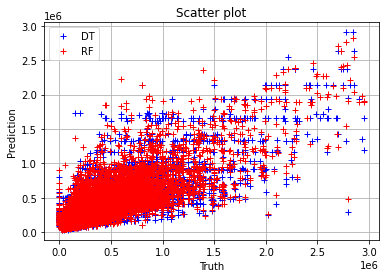

In [11]:
plt.plot(y_test, y_pred_DT, '+', color='blue')
plt.plot(y_test, y_pred_RF, '+', color='red')
plt.title('Scatter plot')
plt.xlabel('Truth'); plt.ylabel('Prediction')
plt.legend(['DT','RF'])
plt.grid(True)

## Features importance model

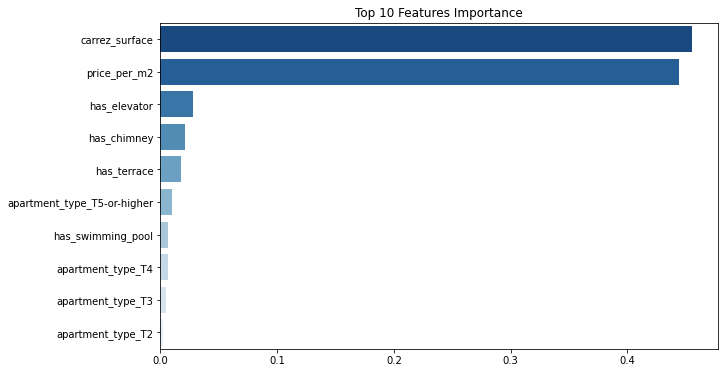

In [12]:
plot_features_importance(X_test, reg.feature_importances_, 10)

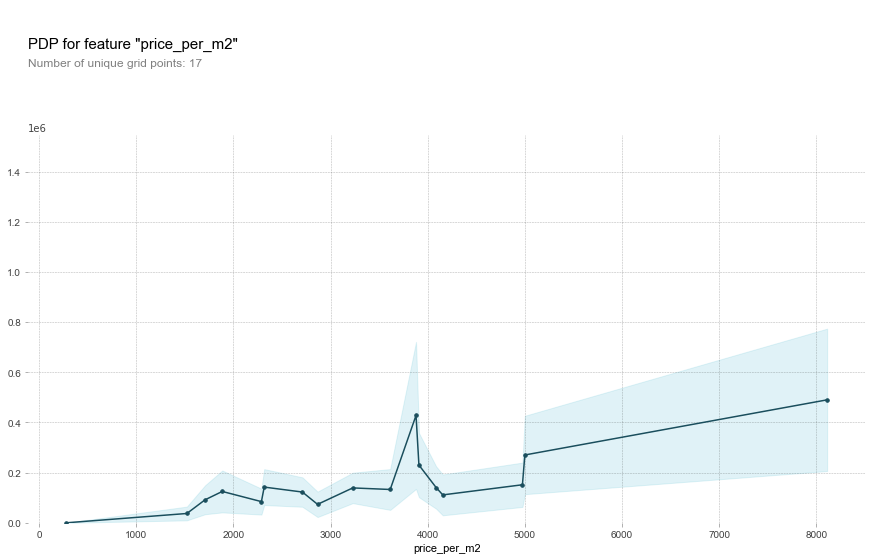

In [13]:
variable = 'price_per_m2'# or 'carrez_surface' 

pdp_goals = pdp.pdp_isolate(model=reg,
                            dataset=X_test,
                            model_features=X_test.columns,
                            feature=variable,
                            num_grid_points=20,
                            grid_type='percentile', #possible values: 'equal' or 'percentile'
)

pdp.pdp_plot(pdp_goals, variable, center=True) # center arg center plots and compare each value to the first one
plt.show()

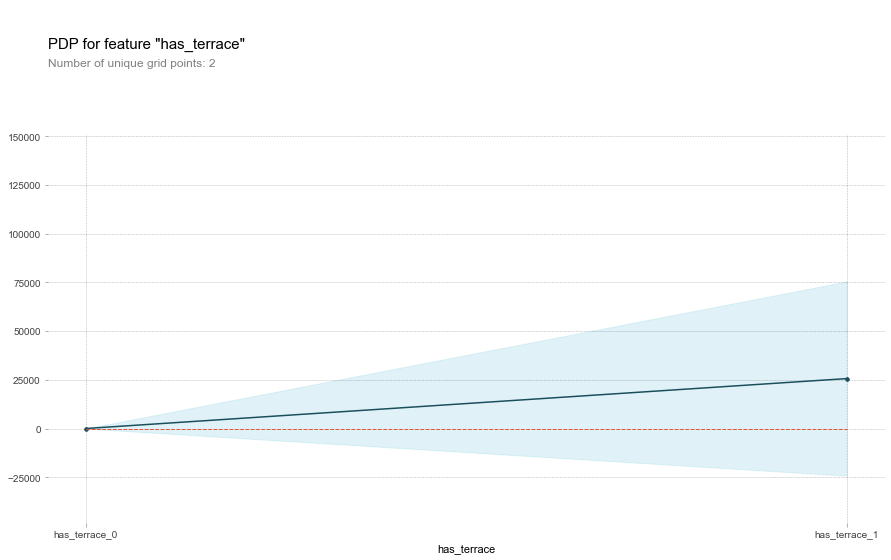

In [14]:
feature = 'has_terrace' #or 'has_swimming_pool', 'has_chimney', 'has_elevator'
pdp_binary = pdp.pdp_isolate(model=reg, dataset=X_test,
                             model_features=X_test.columns,
                             feature=feature)

fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_binary,
                         feature_name=feature)


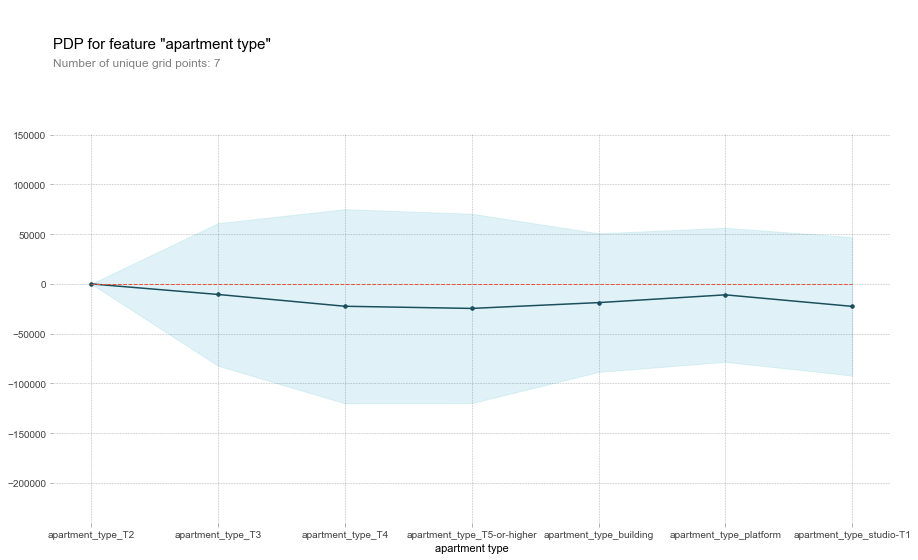

In [16]:
pdp_apartment_type = pdp.pdp_isolate(model=reg, dataset=X_test,
                             model_features=X_test.columns,
                             feature=['apartment_type_T2', 'apartment_type_T3', 'apartment_type_T4',
                                       'apartment_type_T5-or-higher', 'apartment_type_building',
                                       'apartment_type_platform', 'apartment_type_studio-T1'])

fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_apartment_type,
                         feature_name='apartment type')

In [19]:
fig.savefig('./pdp_test.png')

In [16]:
#inter1 = pdp.pdp_interact(reg, X_test, X_test.columns, 
#                          features=['price_per_m2','carrez_surface'], 
#                          num_grid_points=[10, 10],
#                          percentile_ranges=None)
#fig, axes = pdp.pdp_interact_plot(pdp_interact_out=inter1,
#                                  feature_names=['price_per_m2','carrez_surface'],
#                                  plot_type='grid',
#                                  x_quantile=True,
#                                 plot_pdp=True)

In [17]:
if 0: #ICE 
    variable = 'carrez_surface' 
    X_ref = X_test.copy().sample(100, random_state=42)

    ice_df = ice(X_ref, variable, reg.predict, num_grid_points=20)

    fig, ax_ice = plt.subplots(nrows=1, ncols=1,figsize=(10, 6))

    ice_plot(ice_df, plot_points=True, point_kwargs={'color': 'k', 'alpha': 0.75}, c='g',
             alpha=0.1, plot_pdp=True, ax=ax_ice)
    plt.grid(True)

    ax_ice.set_xlabel(variable)
    ax_ice.set_ylabel('Prediction') 
    ax_ice.set_title('ICE Curves')

## Shap : Tree Explainer (Artefact?)

In [17]:
shap.initjs()

In [18]:
%%time
X_test_shap = X_test.head(100)
explanation = shap.TreeExplainer(reg)
shap_values = explanation.shap_values(X_test_shap)
df_contrib = pd.DataFrame(shap_values, columns=X_test_shap.columns, index=X_test_shap.index)
bias = explanation.expected_value

CPU times: user 4.79 s, sys: 132 ms, total: 4.92 s
Wall time: 6.11 s


In [19]:
print(f'Biais/__BASE RATE__ : {round(bias[0],2)}€')

Biais/__BASE RATE__ : 275441.49€


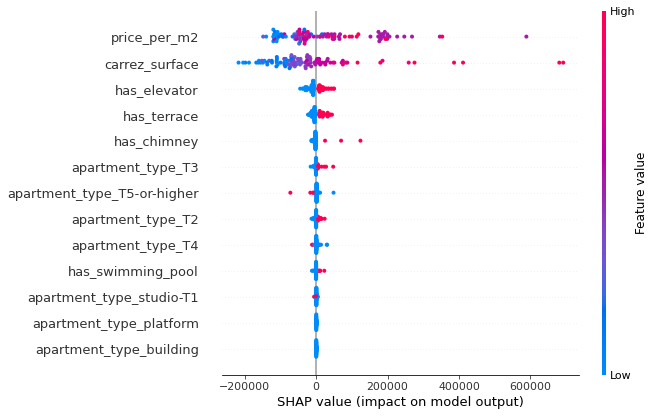

AttributeError: 'NoneType' object has no attribute 'savefig'

In [20]:
shap.summary_plot(shap_values, X_test_shap, plot_type="dot")

In [22]:
# random example
if 0:
    index = 27
    shap.plots._waterfall.waterfall_legacy(expected_value=explanation.expected_value[0],
                                       shap_values=shap_values[index, :],
                                       feature_names=X_test_shap.columns)

In [23]:
# example with and without terrace
if 0:
    print(X_test_shap[X_test_shap.index.isin([0,1])])

    index = 0
    shap.plots._waterfall.waterfall_legacy(expected_value=explanation.expected_value[0],
                                           shap_values=shap_values[index, :],
                                           feature_names=X_test_shap.columns)

    index = 1
    shap.plots._waterfall.waterfall_legacy(expected_value=explanation.expected_value[0],
                                           shap_values=shap_values[index, :],
                                           feature_names=X_test_shap.columns)

In [24]:
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode(connected=True)

In [25]:
interpretable_dict = prepare_interpretable_contribution(X_test_shap, reg.predict, df_contrib, bias[0])

index = 1 # You can change this parameter to change the consumer.
num_features_plot = 3
is_horizontal = True

print(X_test_shap[X_test_shap.index==index])

fig = plot_observation_contribution(interpretable_dict=interpretable_dict,
                                    index_ref=index,
                                    num_features_plot=num_features_plot,
                                    is_horizontal=is_horizontal)
offline.iplot(fig)

   has_terrace  has_swimming_pool  has_chimney  has_elevator  \
1            0                  0            0             0   

   apartment_type_T2  apartment_type_T3  apartment_type_T4  \
1                  1                  0                  0   

   apartment_type_T5-or-higher  apartment_type_building  \
1                            0                        0   

   apartment_type_platform  apartment_type_studio-T1  price_per_m2  \
1                        0                         0   1885.714286   

   carrez_surface  
1           56.12  


/Users/corentinvasseur/Desktop/FormationYotta/projet/gitlab/.venv/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:405: DeprecationWarning:

plotly.graph_objs.Margin is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Margin




## Train.py

In [26]:
reg = ensemble.RandomForestRegressor(n_estimators= 130, max_depth= 11, random_state=42)

X = pd.concat([X_train, X_test])
y = np.ravel(pd.concat([y_train, y_test], axis=0))

reg.fit(X, y)

score = reg.score(X , y)
print(f'Score R2 entire dataset {round(score, 2)}')

predictions = reg.predict(X)

Score R2 entire dataset 0.73


In [27]:
r2 = round(r2_score(y, predictions), 2)
mae = round(mean_absolute_error(y, predictions), 1)
#mse = round(mean_squared_error(y, predictions),1)
#rmse = round(mean_squared_error(y, predictions, squared=False),1)
print(f'r2: {r2}, mae: {mae}')

r2: 0.73, mae: 84263.7
